# Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2

from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm 

# Setting up hardware

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices != []:
    print("Using GPU")
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)
else:
    print("Using CPU")
    pass

Using GPU


# Load Dataset

In [3]:
root_dir = str(input("Path where 'classify train' directory belongs: "))
classify_train = os.path.join(root_dir, 'classify train')

train_directory = os.path.join(classify_train, 'training')
validation_directory = os.path.join(classify_train, 'validation')
test_directory = os.path.join(classify_train, 'testing')

Path where 'classify train' directory belongs: /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o


In [4]:
train_directory, validation_directory, test_directory

('/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/classify train/training',
 '/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/classify train/validation',
 '/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/classify train/testing')

# Hyper-parameter setting-1

In [5]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))
lambd = float(input("Enter lambda for L2 regularization: "))

Enter the initial learning rate: 0.001
Enter the maximum number of epochs: 100
Enter batch size: 8
Enter lambda for L2 regularization: 0.00001


# Characteristics folder
Creating a seperate folder where 'classify train' belongs to store model and results

In [6]:
char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(root_dir, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char)
        os.mkdir(char)
    elif replace.upper() == 'N':
        print('\nThe following folders already exist:')
        for i in os.listdir(root_dir): 
            print(i)
        char_name = str(input("\nEnter a new name of the characteristics folder: "))
        char = os.path.join(root_dir, char_name)
        if not os.path.exists(char):
            os.mkdir(char)
        else:
            print(f"{char_name} replaced")
            shutil.rmtree(char)
            os.mkdir(char)

Enter name of the characteristics folder: mobile_inception_1


# Learning rate decay

In [7]:
steps = 10 # change steps to 1 to apply exponential decay

def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / steps))
    
best_model_address = os.path.join(char, 'best_model.h5')

# Callbacks

In [8]:
monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


if monitor == 1:
    metric = 'val_accuracy'
    mode = 'max'
    print("\nMONITORING VALIDATION ACCURACY..........\n")

elif monitor == 2:
    metric = 'val_loss'
    mode = 'min'
    print("\nMONITORING VALIDATION LOSS..........\n")

elif monitor == 3:
    metric = 'accuracy'
    mode = 'max'
    print("\nMONITORING TRAINING ACCURACY..........\n")

elif monitor == 4:
    metric = 'loss'
    mode = 'min'
    print("\nMONITORING TRAINING LOSS..........\n")

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode)]

print(f"\nTraining will stop if {metric} doesn't show any improvements for {patience} epcohs\n")

Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4
Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: 10

MONITORING TRAINING LOSS..........


Training will stop if loss doesn't show any improvements for 10 epcohs



# Model Architecture

In [9]:
def mobile_inception(dim, output_neurons, output_activation):
    print("\nTRAINING ON mobile_inception MODEL:-")

    
    def block(x, filters, reps):
        for _ in range(reps):
            # for low-level features
            t1 = Conv2D(filters[0], kernel_size = (1,1))(x)
            t1 = LeakyReLU()(t1)

            # for mid-level features
            t2 = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
            t2 = LeakyReLU()(t2)
            t2 = Conv2D(filters[1], kernel_size = (1,1))(t2)
            t2 = LeakyReLU()(t2)

            # for high-level features
            t3 = DepthwiseConv2D(kernel_size = (5,5), strides = 1, padding = 'same')(x)
            t3 = LeakyReLU()(t3)
            t3 = Conv2D(filters[2], kernel_size = (1,1))(t3)
            t3 = LeakyReLU()(t3)

            # for most-significant features
            t4 = MaxPool2D(pool_size = (3,3), strides = 1, padding = 'same')(x)
            t4 = Conv2D(filters[3], kernel_size = (1,1))(t4)
            t4 = LeakyReLU()(t4)

            x = Concatenate()([t1, t2, t3, t4])
        
        return x
        
        
    input = Input(shape = dim)
    
    k = 16
    
    x = Conv2D(filters = k, kernel_size = (7,7), strides = 2, padding = 'same')(input)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same')(x)
    
    x = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters = 2*k, kernel_size = (1,1))(x)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)
    
    x = block(x, [k, k, k, k], reps = 2)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)
    
    x = block(x, [2*k, 2*k, 2*k, 2*k], reps = 2)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)

    x = block(x, [4*k, 4*k, 4*k, 4*k], reps = 2)
     
    x = GlobalAveragePooling2D()(x)
    #x = Dropout(0.4)(x)
    
    output = Dense(output_neurons, output_activation)(x)
    
    model = Model(inputs = input, outputs = output)    
    
    return model

In [10]:
def pooled_mobile(dim, output_neurons, output_activation):
    print("\nTRAINING ON pooled_mobile MODEL:-")

    
    def block(x, n_filters, d_strides):
        # depthwise
        x = DepthwiseConv2D(kernel_size = (3,3), strides = d_strides, padding = 'same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    
        # pointwise
        x = Conv2D(filters = n_filters, kernel_size = (1,1))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        
        # max-pool
        x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
    
        return x
    
    
    input = Input(shape = dim)
    
    k = 16
    x = Conv2D(filters = k, kernel_size = (3,3), strides = 2, padding = 'same')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = block(x, n_filters = 2*k, d_strides = 1)

    x = block(x, n_filters = 4*k, d_strides = 1)    

    x = block(x, n_filters = 8*k, d_strides = 1)    

    x = block(x, n_filters = 16*k, d_strides = 1)
    x = Dropout(0.2)(x)

    x = block(x, n_filters = 32*k, d_strides = 1)
    
    x = GlobalAveragePooling2D()(x)
    
    output = Dense(output_neurons, output_activation)(x)  
    
    model = Model(inputs = input, outputs = output)
    
    return model

In [11]:
class_no = len(os.listdir(train_directory))

print("This is a " + str(class_no) + "-Class Classification")

if class_no <= 2:
    class_mode = 'binary'
    output_activation = 'sigmoid'
    output_neurons = 1
    losses = 'binary_crossentropy'

else:
    class_mode = 'categorical'
    output_activation = 'softmax'
    output_neurons = class_no
    losses = 'categorical_crossentropy'

This is a 2-Class Classification


In [12]:
def optimizer_selection():
    print("\nSelect a optimizer which will reduce the loss of the model.\n")

    optimizer_select = int(input("Press 1 to select Stochastic Gradient Descent\nPress 2 to select RMSprop\nPress 3 to select Adagrad\nPress 4 to select Adadelta\nPress 5 to select Adam\nPress 6 to select Adamax\nPress 7 to select Nadam\n"))

    if optimizer_select == 1:
        optimizer = SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

    elif optimizer_select == 2:
        optimizer = RMSprop(learning_rate, rho = 0.9)

    elif optimizer_select == 3:
        optimizer = Adagrad(learning_rate)

    elif optimizer_select == 4:
        optimizer = Adadelta(learning_rate, rho = 0.95)

    elif optimizer_select == 5:
        optimizer = Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    elif optimizer_select == 6:
        optimizer = Adamax(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)

    elif optimizer_select == 7:
        optimizer = Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
   
    return optimizer

In [13]:
h = int(input("Image Dimension(H or W): "))
w = h
color = int(input("Press 1 for RGB \nPress 2 for Grayscale "))
if color == 1:
    color_mode = 'rgb'
    dim = (h,w,3)
elif color == 2:
    color_mode = 'grayscale'
    dim = (h,w,1)

Image Dimension(H or W): 128
Press 1 for RGB 
Press 2 for Grayscale 1


In [14]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_directory,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    color_mode = color_mode,
                                                    target_size = (h,w),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(validation_directory,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              color_mode = color_mode,
                                                              target_size = (h,w),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  color_mode = color_mode,
                                                  target_size = (h,w),
                                                  shuffle=True)

Found 7752 images belonging to 2 classes.
Found 969 images belonging to 2 classes.
Found 969 images belonging to 2 classes.


In [15]:
optimizer = optimizer_selection()


Select a optimizer which will reduce the loss of the model.

Press 1 to select Stochastic Gradient Descent
Press 2 to select RMSprop
Press 3 to select Adagrad
Press 4 to select Adadelta
Press 5 to select Adam
Press 6 to select Adamax
Press 7 to select Nadam
5


In [16]:
model = mobile_inception(dim, output_neurons, output_activation)
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()


TRAINING ON mobile_inception MODEL:-
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   2368        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 16)   0           leaky_re_lu[0][0]                
________________________________________________________

In [17]:
with tf.device('/GPU:0'):
    start = time.time()
    history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle=True)

    end = time.time()
    
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
969/969 [==============================] - 25s 22ms/step - loss: 0.6545 - accuracy: 0.5843 - precision: 0.5991 - recall: 0.8034 - true_positives: 1604.4495 - true_negatives: 719.8588 - false_positives: 1015.4660 - false_negatives: 544.2175 - val_loss: 0.4420 - val_accuracy: 0.7740 - val_precision: 0.8362 - val_recall: 0.7307 - val_true_positives: 388.0000 - val_true_negatives: 362.0000 - val_false_positives: 76.0000 - val_false_negatives: 143.0000

Epoch 00001: loss improved from inf to 0.60344, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/mobile_inception_1/best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
969/969 [==============================] - 20s 20ms/step - loss: 0.4044 - accuracy: 0.7982 - precision: 0.8653 - recall: 0.7508 - true_positives: 1657.7629 - true_negativ


Epoch 00012: loss improved from 0.01714 to 0.01245, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/mobile_inception_1/best_model.h5
Epoch 13/100

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0001.
969/969 [==============================] - 19s 20ms/step - loss: 0.0095 - accuracy: 0.9963 - precision: 0.9944 - recall: 0.9989 - true_positives: 2139.4990 - true_negatives: 1728.6959 - false_positives: 12.6093 - false_negatives: 3.1876 - val_loss: 0.0156 - val_accuracy: 0.9928 - val_precision: 0.9870 - val_recall: 1.0000 - val_true_positives: 531.0000 - val_true_negatives: 431.0000 - val_false_positives: 7.0000 - val_false_negatives: 0.0000e+00

Epoch 00013: loss improved from 0.01245 to 0.01127, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/mobile_inception_1/best_model.h5
Epoch 14/100

Epoch 00014: 

969/969 [==============================] - 19s 20ms/step - loss: 0.0059 - accuracy: 0.9975 - precision: 0.9955 - recall: 1.0000 - true_positives: 2136.5701 - true_negatives: 1738.3753 - false_positives: 9.0464 - false_negatives: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_true_positives: 531.0000 - val_true_negatives: 438.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00

Epoch 00024: loss improved from 0.00531 to 0.00519, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/mobile_inception_1/best_model.h5
Epoch 25/100

Epoch 00025: LearningRateScheduler reducing learning rate to 1.0000000000000003e-05.
969/969 [==============================] - 20s 20ms/step - loss: 0.0046 - accuracy: 0.9980 - precision: 0.9964 - recall: 1.0000 - true_positives: 2149.3340 - true_negatives: 1726.6134 - false_positives: 8.0443 - false_negati


Epoch 00034: loss improved from 0.00394 to 0.00392, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/mobile_inception_1/best_model.h5
Epoch 35/100

Epoch 00035: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
969/969 [==============================] - 20s 20ms/step - loss: 0.0035 - accuracy: 0.9986 - precision: 0.9974 - recall: 1.0000 - true_positives: 2136.4773 - true_negatives: 1742.2361 - false_positives: 5.2784 - false_negatives: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_true_positives: 531.0000 - val_true_negatives: 438.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00

Epoch 00035: loss improved from 0.00392 to 0.00391, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/mobile_inception_1/best_model.h5
Epoc

969/969 [==============================] - 20s 20ms/step - loss: 0.0031 - accuracy: 0.9992 - precision: 0.9985 - recall: 1.0000 - true_positives: 2134.6423 - true_negatives: 1745.7969 - false_positives: 3.5526 - false_negatives: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_true_positives: 531.0000 - val_true_negatives: 438.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00
Restoring model weights from the end of the best epoch.

Epoch 00045: loss improved from 0.00380 to 0.00380, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/PUCHO/bio_marker/Coswara/Aug_Data/balanced_mel_spectrogram/vowel_o/mobile_inception_1/best_model.h5
Epoch 00045: early stopping
122/122 [==============================] - 2s 13ms/step - loss: 0.0052 - accuracy: 0.9990 - precision: 0.9981 - recall: 1.0000 - true_positives: 531.0000 - true_negatives: 437.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00


In [18]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 891.3370380401611 seconds


# Plot characteristic curves

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

In [20]:
print(epochs)

range(0, 45)


In [21]:
x_tick = []
i = 0
for i in epochs:
    if i%8 == 0:
        x_tick.append(i)

x_tick

[0, 8, 16, 24, 32, 40]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


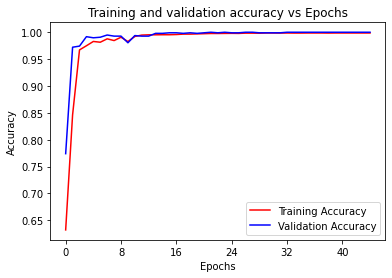

In [22]:
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

plt.xlabel("Epochs")
plt.xticks(x_tick)
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()

fig_name_eps = "accuracy.eps"
fig_name_jpg = "accuracy.jpg"

plt.savefig(os.path.join(char, fig_name_eps))
plt.savefig(os.path.join(char, fig_name_jpg))

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


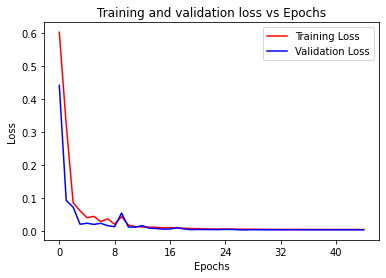

In [23]:
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")

plt.xlabel("Epochs")
plt.xticks(x_tick)
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()

fig_name_eps = "loss.eps"
fig_name_jpg = "loss.jpg"

plt.savefig(os.path.join(char, fig_name_eps))
plt.savefig(os.path.join(char, fig_name_jpg))

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


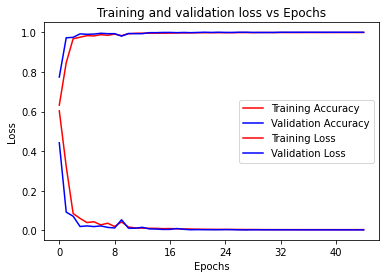

In [24]:
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")

plt.xlabel("Epochs")
plt.xticks(x_tick)
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()

fig_name_eps = "char.eps"
fig_name_jpg = "char.jpg"

plt.savefig(os.path.join(char, fig_name_eps))
plt.savefig(os.path.join(char, fig_name_jpg))

# Classification metrices

In [25]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 99.85809922218323 %
The validation accuracy is: 100.0 %
The test accuracy is: 99.89680051803589 %


In [26]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity_k = (tp/(tp+fn))*100
specificity_k = (tn/(tn+fp))*100

In [27]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("Sensitivity_k: {}".format(sensitivity_k))
print("Specificity_k: {}".format(specificity_k))

Test Accuracy: 99.89680051803589
Test Precision: 99.81203079223633
Test Recall: 100.0
True Positive: 531
Test Negetive: 437
False Positive: 1
False Negetive: 0
Sensitivity_k: 100.0
Specificity_k: 99.77168949771689


In [60]:
def report(y_true, y_pred, labels):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix 
    
    print("Calculating CLASSIFICATION REPORT: ")
    classification_reports = classification_report(y_true, y_pred, target_names=labels)
    print(classification_reports)

    print("\nCalculating SENSITIVITY & SPECIFICITY..........:")
    cm = confusion_matrix(y_true, y_pred)
    total = sum(sum(cm))
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    print("sensitivity = {:.4f}".format(sensitivity))
    print("specificity = {:.4f}".format(specificity))
    
    return cm, classification_reports, sensitivity, specificity

In [61]:
def conf_mat(cm, labels, char, file_name):
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                    colorbar=True,
                                    show_absolute=True,
                                    class_names=labels,
                                    show_normed=True)

    plt.savefig(os.path.join(char, f'{file_name}.eps'))
    plt.savefig(os.path.join(char, f'{file_name}.jpg'))

In [48]:
labels = test_generator.class_indices

In [69]:
labels = {'Normal': 0, 'COVID': 1}

# Classification result (Keras)

In [70]:
def pred_keras(tp, tn, fp, fn):
    y_true = []
    y_pred = []

    for i in range(tp):
        y_true.append(1)
        y_pred.append(1)

    for i in range(tn):
        y_true.append(0)
        y_pred.append(0)

    for i in range(fp):
        y_true.append(0)
        y_pred.append(1)

    for i in range(fn):
        y_true.append(1)
        y_pred.append(0)
            
    return y_true, y_pred

In [71]:
y_true, y_pred = pred_keras(tp, tn, fp, fn)

In [72]:
cm, classification_reports_keras, sensitivity_keras, specificity_keras = report(y_true, y_pred, labels)

Calculating CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       438
       COVID       1.00      1.00      1.00       531

    accuracy                           1.00       969
   macro avg       1.00      1.00      1.00       969
weighted avg       1.00      1.00      1.00       969


Calculating SENSITIVITY & SPECIFICITY..........:
sensitivity = 0.9977
specificity = 1.0000


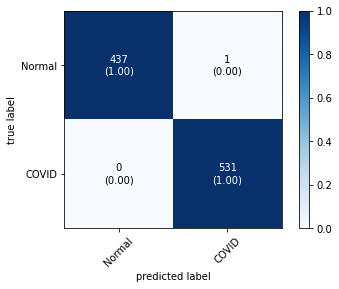

In [73]:
conf_mat(cm, labels, char, 'confusion-matrix-keras')

# Classification result (Scikit-learn)

In [74]:
def pred_sklearn(test_directory, test_generator, class_no, best_model_address, dim):
    test_class_list = []
    for test_name in os.listdir(test_directory):
        test = os.path.join(test_directory, test_name)
        test_class_list.append(test)
    test_class_list.sort()
    
    y_true = test_generator.classes
    labels = test_generator.class_indices
    
    y_pred = []
    tot = len(os.listdir(test_class_list[1]))*class_no

    best_model = load_model(best_model_address)
    
    with tqdm(total=tot) as pbar:
        for i in range(class_no):
            for filename in os.listdir(test_class_list[i]):
                file = os.path.join(test_class_list[i], filename)
                img = cv2.imread(file)
                res = cv2.resize(img, (dim[0], dim[1]))
                normed = res / 255.0
                im_arr = normed.reshape(1, dim[0], dim[1], dim[2])

                pred = best_model.predict(im_arr)
                pred_categorical = keras.utils.to_categorical(pred)

                if class_no >= 2:
                    max_pred = np.argmax(pred)
                else:
                    max_pred = np.argmax(pred_categorical)

                y_pred.append(max_pred)

                pbar.set_description("Progress")
                pbar.update()
                
    return y_true, y_pred, labels

In [75]:
y_true, y_pred, labels = pred_sklearn(test_directory, test_generator, class_no, best_model_address, dim)

Progress:  91%|███████████████████████████▎  | 969/1062 [00:47<00:04, 20.57it/s]


In [76]:
cm, classification_reports_sklearn, sensitivity_sklearn, specificity_sklearn = report(y_true, y_pred, labels)

Calculating CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

       covid       0.45      1.00      0.62       438
     healthy       0.00      0.00      0.00       531

    accuracy                           0.45       969
   macro avg       0.23      0.50      0.31       969
weighted avg       0.20      0.45      0.28       969


Calculating SENSITIVITY & SPECIFICITY..........:
sensitivity = 1.0000
specificity = 0.0000


/mnt/87433d53-66f3-438e-a7f4-fc990fe61283/PROJECTS/PRODUCTS/Computer-Vision-Research/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/87433d53-66f3-438e-a7f4-fc990fe61283/PROJECTS/PRODUCTS/Computer-Vision-Research/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/87433d53-66f3-438e-a7f4-fc990fe61283/PROJECTS/PRODUCTS/Computer-Vision-Research/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined an

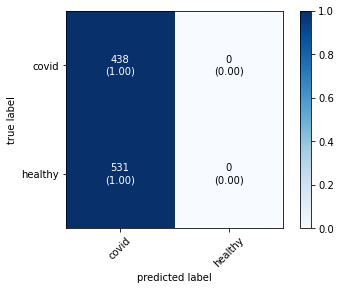

In [78]:
conf_mat(cm, labels, char, 'confusion-matrix-sklearn')

# README

In [79]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print(f"Please read the text file named {readme_name_text} for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if len(os.listdir(train_directory)) > 2:
    readme.write(f"This is a {len(os.listdir(train_directory))}-class CLASSIFICATION")
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write(f"\nInitial Learning Rate = {learning_rate}")
readme.write(f"\nNo. of epochs = {len(acc)}")
readme.write(f"\nBatch Size = {batch_size}")


readme.write("\n\n--MODEL-PARAMETERS--")
# readme.write(f"\nDropout for feature extraction = {(int(f_dropout*100))} %")
# readme.write(f"\nDropout for dense layer = {(int(d_dropout*100))} %")
readme.write(f"\nOptimizer = {optimizer}\n\n")


readme.write("Trained on a Custom Prebuilt Model\n")
# readme.write(f"\nFilter size = {size_filter}x{size_filter}\n\n")
with redirect_stdout(readme):
    model.summary()
        
    
readme.write("\n\n--MODEL-PERFORMANCE--")
readme.write(f"\nTest Accuracy = {test_accuracy} %")
readme.write(f"\nTest Precision = {test_precision} %")
readme.write(f"\nTest Recall = {test_recall} %")
readme.write(f"\nTrue Positive = {tp}")
readme.write(f"\nTrue Negetive = {tn}")
readme.write(f"\nFalse Positive = {fp}")
readme.write(f"\nFalse Negetive = {fn}")
readme.write(f"\nSensitivity_k = {sensitivity_k}")
readme.write(f"\nSpecificity_k = {specificity_k}\n\n\n")


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write(f"\nacc = {acc}")
readme.write(f"\n\nval_acc = {val_acc}")
readme.write(f"\n\nloss = {loss}")
readme.write(f"\n\nval_loss = {val_loss}")


readme.write("\n\n--Classification Report Keras--\n")
readme.write(classification_reports_keras)
readme.write(f"\nSensitivity = {sensitivity_keras*100} %")
readme.write(f"\nSpecificity = {specificity_keras*100} %")

readme.write("\n\n--Classification Report Scikit-learn--\n")
readme.write(classification_reports_sklearn)
readme.write(f"\nSensitivity = {sensitivity_sklearn*100} %")
readme.write(f"\nSpecificity = {specificity_sklearn*100} %")


readme.write(f"\nExecution Time: {duration} seconds")

readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
